In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms, datasets
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

DATA_DIR = "/kaggle/input/malimg-original/malimg_paper_dataset_imgs"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 25
EPOCHS = 20
LEARNING_RATE = 1e-4

Using device: cuda


In [3]:
print("Menghitung mean dan std dataset...")

temp_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

temp_dataset = datasets.ImageFolder(root=DATA_DIR, transform=temp_transform)
loader = DataLoader(temp_dataset, batch_size=256, shuffle=False, num_workers=2)

mean = 0.
std = 0.
total_samples = 0
for data, _ in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    total_samples += batch_samples

mean /= total_samples
std /= total_samples
print(f"Dataset grayscale mean: {mean.item():.4f}, std: {std.item():.4f}")


Menghitung mean dan std dataset...
Dataset grayscale mean: 0.4455, std: 0.1723


In [4]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((int(IMG_SIZE * 1.1), int(IMG_SIZE * 1.1))),
    transforms.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.95, 1.0), ratio=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),
    transforms.RandomApply([
        transforms.Lambda(lambda x: torch.clamp(x + torch.randn_like(x) * 0.01, 0, 1))
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [5]:
raw_dataset = datasets.ImageFolder(root=DATA_DIR)
all_targets = [label for _, label in raw_dataset.samples]
all_indices = list(range(len(raw_dataset)))

train_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.2,
    stratify=all_targets,
    random_state=42
)

train_dataset_raw = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
test_dataset_raw = datasets.ImageFolder(root=DATA_DIR, transform=test_transform)

train_dataset = Subset(train_dataset_raw, train_idx)
test_dataset = Subset(test_dataset_raw, test_idx)

train_targets = [all_targets[i] for i in train_idx]
class_counts = Counter(train_targets)
weights = [1.0 / class_counts[train_targets[i]] for i in range(len(train_targets))]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = raw_dataset.classes


In [6]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)

# Modifikasi patch embedding untuk 1 channel
model.patch_embed.proj = nn.Conv2d(
    in_channels=1,
    out_channels=model.patch_embed.proj.out_channels,
    kernel_size=model.patch_embed.proj.kernel_size,
    stride=model.patch_embed.proj.stride,
    bias=model.patch_embed.proj.bias is not None
)
nn.init.xavier_uniform_(model.patch_embed.proj.weight)
if model.patch_embed.proj.bias is not None:
    nn.init.zeros_(model.patch_embed.proj.bias)

# Ganti head dengan dropout
model.head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.head.in_features, NUM_CLASSES)
)

model.to(DEVICE)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [7]:
alpha_vals = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
alpha_tensor = torch.tensor(alpha_vals, dtype=torch.float).to(DEVICE)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_pt = torch.nn.functional.log_softmax(inputs, dim=1)
        pt = log_pt.exp()
        log_pt = log_pt.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_weight = alpha_t * (1 - pt) ** self.gamma
        else:
            focal_weight = (1 - pt) ** self.gamma
        loss = -focal_weight * log_pt
        return loss.mean() if self.reduction == 'mean' else loss.sum()

criterion = FocalLoss(gamma=2, alpha=alpha_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validasi
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_loss_avg = val_loss / len(test_loader)
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss_avg)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss_avg:.4f}, Acc: {val_acc:.2f}%")


Epoch 1/20 | Train Loss: 1.6029, Acc: 59.66% | Val Loss: 0.2377, Acc: 39.94%
Epoch 2/20 | Train Loss: 0.2262, Acc: 83.20% | Val Loss: 0.4357, Acc: 40.04%
Epoch 3/20 | Train Loss: 0.1871, Acc: 85.50% | Val Loss: 0.1370, Acc: 71.04%
Epoch 4/20 | Train Loss: 0.1307, Acc: 89.20% | Val Loss: 0.3524, Acc: 39.45%
Epoch 5/20 | Train Loss: 0.1185, Acc: 88.52% | Val Loss: 0.1075, Acc: 64.24%
Epoch 6/20 | Train Loss: 0.0867, Acc: 90.82% | Val Loss: 0.0884, Acc: 79.34%
Epoch 7/20 | Train Loss: 0.0728, Acc: 91.88% | Val Loss: 0.0838, Acc: 69.38%
Epoch 8/20 | Train Loss: 0.1147, Acc: 90.24% | Val Loss: 0.1215, Acc: 64.83%
Epoch 9/20 | Train Loss: 0.0971, Acc: 91.06% | Val Loss: 0.1539, Acc: 83.62%
Epoch 10/20 | Train Loss: 0.1770, Acc: 89.57% | Val Loss: 0.0783, Acc: 70.93%
Epoch 11/20 | Train Loss: 0.0420, Acc: 93.39% | Val Loss: 0.0676, Acc: 87.58%
Epoch 12/20 | Train Loss: 0.0600, Acc: 92.76% | Val Loss: 0.0879, Acc: 77.30%
Epoch 13/20 | Train Loss: 0.0552, Acc: 93.52% | Val Loss: 0.0559, Acc: 87

In [9]:
torch.save(model.state_dict(), "vit_malimg_optimized.pth")
print("\n Model disimpan sebagai 'vit_malimg_optimized.pth'")


 Model disimpan sebagai 'vit_malimg_optimized.pth'


 Laporan per kelas (precision, recall, F1) disimpan sebagai 'ViT_optimized_per_class_metrics.csv'
 Confusion matrix (CSV) disimpan
 Confusion matrix (PNG) disimpan
 Kurva pelatihan disimpan

 Ringkasan akhir disimpan sebagai 'ViT_optimized_summary.csv'

 Training & evaluasi selesai! Semua file hasil tersedia.


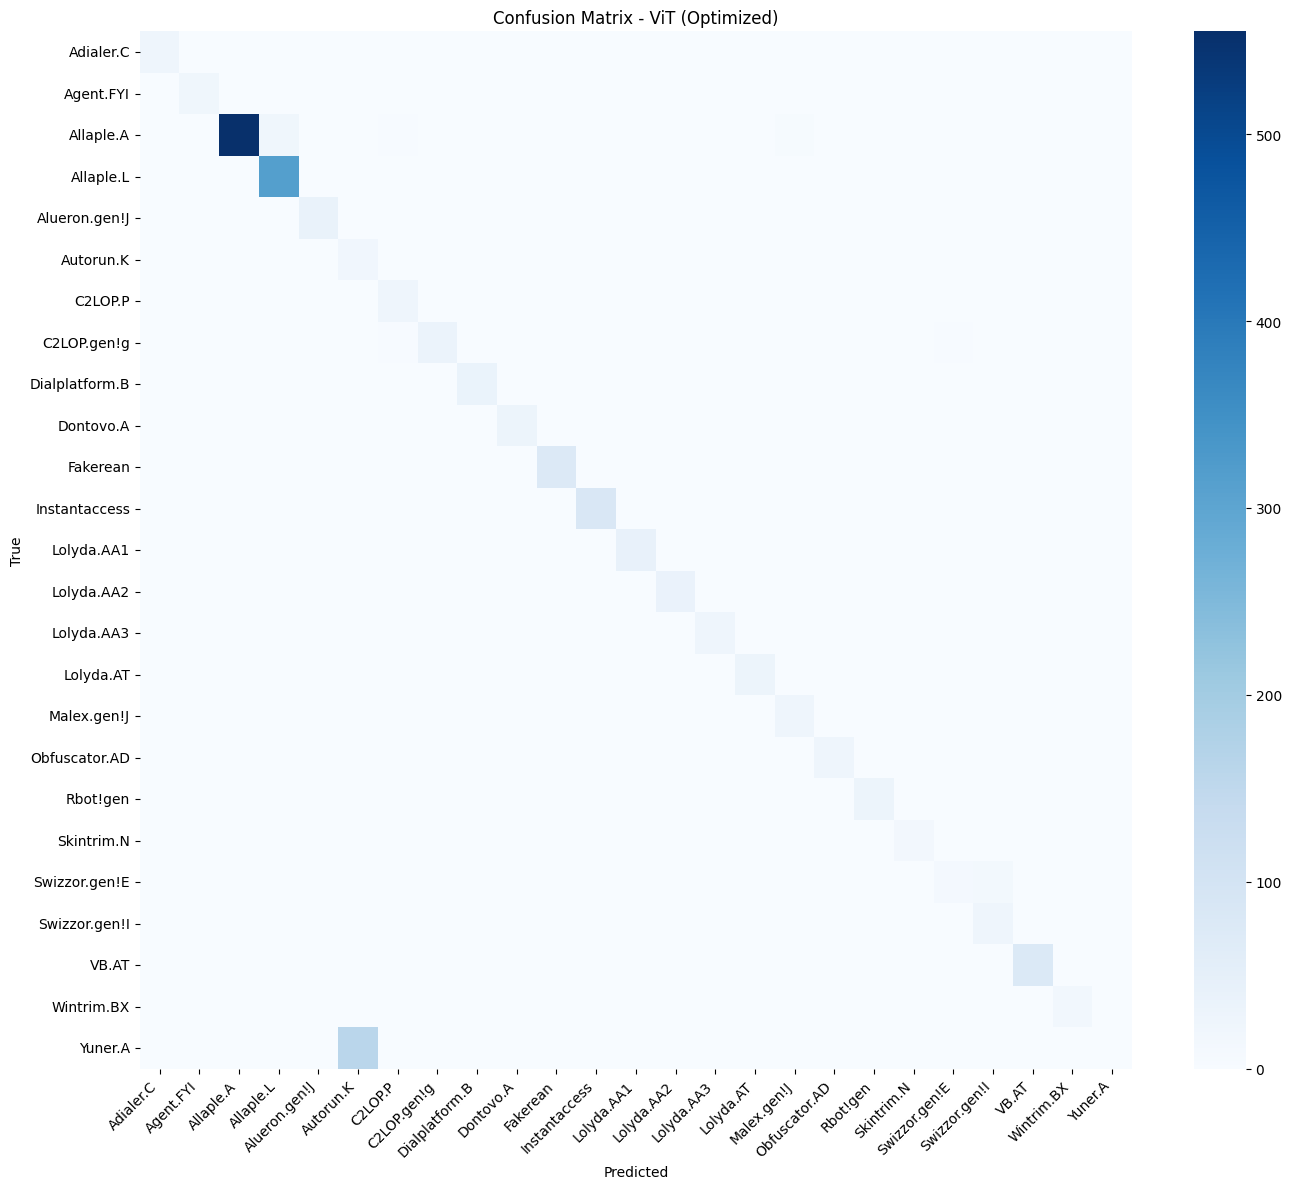

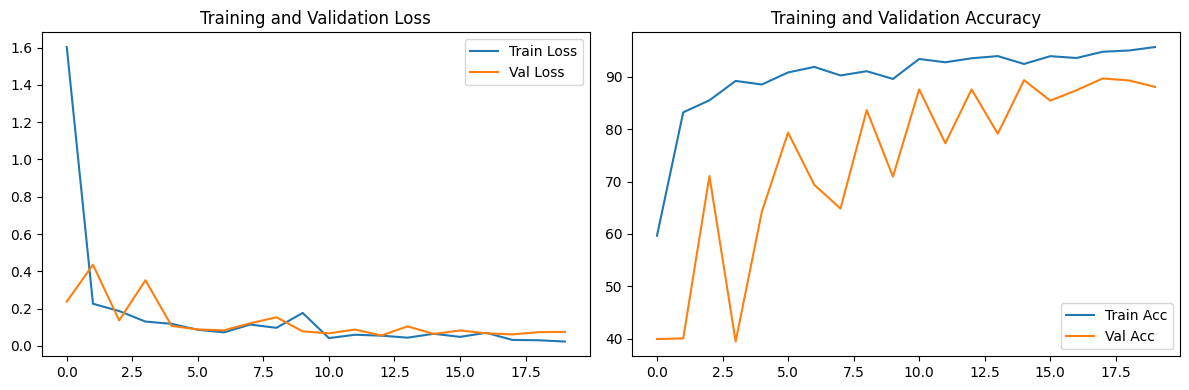

In [10]:
model.eval()
all_preds = []
all_labels = []
inference_times = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        start = time.time()
        outputs = model(inputs)
        end = time.time()
        inference_times.append(end - start)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# --- Metrik Utama ---
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, labels=range(NUM_CLASSES), zero_division=0
)
precision_avg = np.mean(precision)
recall_avg = np.mean(recall)
f1_avg = np.mean(f1)

# --- Simpan Laporan Per Kelas (Precision, Recall, F1) ---
report_df = pd.DataFrame({
    'class': class_names,
    'precision': precision,
    'recall': recall,
    'f1-score': f1,
    'support': support
})
report_df.to_csv("ViT_optimized_per_class_metrics.csv", index=False)
print(" Laporan per kelas (precision, recall, F1) disimpan sebagai 'ViT_optimized_per_class_metrics.csv'")

# --- Confusion Matrix (Visual & CSV) ---
cm = confusion_matrix(all_labels, all_preds)

pd.DataFrame(cm, index=class_names, columns=class_names).to_csv("ViT_optimized_confusion_matrix.csv")
print(" Confusion matrix (CSV) disimpan")


plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix - ViT (Optimized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("ViT_optimized_confusion_matrix.png", dpi=150)
print(" Confusion matrix (PNG) disimpan")

# --- Kurva Pelatihan ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig("ViT_optimized_training_curves.png")
print(" Kurva pelatihan disimpan")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = total_params * 4 / (1024 ** 2)


avg_time_per_image = np.mean(inference_times) / BATCH_SIZE
total_inference_time = sum(inference_times)
throughput = len(test_dataset) / total_inference_time


summary = {
    "Model": "ViT Base (1-Channel + Dropout + Focal Loss)",
    "Accuracy": accuracy,
    "Macro Precision": precision_avg,
    "Macro Recall": recall_avg,
    "Macro F1": f1_avg,
    "Total Params": total_params,
    "Trainable Params": trainable_params,
    "Model Size (MB)": model_size_mb,
    "Avg Inference Time (ms)": avg_time_per_image * 1000,
    "Throughput (img/sec)": throughput,
    "Hardware": str(DEVICE) + (f" ({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "")
}

pd.DataFrame([summary]).to_csv("ViT_optimized_summary.csv", index=False)
print("\n Ringkasan akhir disimpan sebagai 'ViT_optimized_summary.csv'")

print("\n Training & evaluasi selesai! Semua file hasil tersedia.")